In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import mglearn

Step 1: Here I load my data, perform train and test split and only perform feature scaling on my training set.

In [2]:
url = 'https://raw.githubusercontent.com/arianacodes/project-1/main/player_shooting_2023_2024.csv'
df = pd.read_csv(url, index_col=0)
#dropping columns that are repetative or not correlated: 
df = df.drop(['Age', 'Nation','Birth Month','Matches'],axis=1)
df = df[df['Squad'] != 'Squad']                           #removing rows that contained no data

#One Hot Encoding position and team
pos_array = pd.get_dummies(df.Pos)
squad_array = pd.get_dummies(df.Squad)
df = pd.concat([df,pos_array], axis=1)
df = pd.concat([df,squad_array], axis=1)
df = df.drop(['West Ham','GK','Pos','Squad'],axis=1) #dropping one and respective column (*2)

df['Exceeded xG'] = np.where(df['G-xG'] > 0, 1, 0)  #creating binary target attribute
df = df.drop(['Gls','xG','PK','FK','G/Sh','npxG'],axis=1)    #dropping correlated variables

X = df.drop(columns=['Player', 'G-xG'])
y = df['G-xG']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size=0.2)

In [3]:
#preforming smoothing to 0 values
X_train = X_train.replace(np.nan, 0)
X_train[['SoT%','PKatt']] = X_train[['SoT%','PKatt']] + 0.1
X_train[['Sh','SoT','SoT/90','Sh/90']] = X_train[['Sh','SoT','SoT/90','Sh/90']] + 0.1

#Performing log feature scaling to have more Gaussian distributions
transformed = X_train[['Sh','SoT','Sh/90','SoT/90']].transform(lambda x: np.log(x))

X_train = X_train.drop(['Sh','SoT','Sh/90','SoT/90'],axis=1)
X_train = pd.concat([X_train, transformed], axis=1)

X_test = X_test[X_train.columns]

#doing the same thing to X_test
#preforming smoothing to 0 values
X_test = X_test.replace(np.nan, 0)
X_test[['SoT%','PKatt']] = X_test[['SoT%','PKatt']] + 0.1
X_test[['Sh','SoT','SoT/90','Sh/90']] = X_test[['Sh','SoT','SoT/90','Sh/90']] + 0.1

# #Performing log feature scaling to have more Gaussian distributions
# transform = X_test[['Sh','SoT','Sh/90','SoT/90']].transform(lambda x: np.log(x))
X_test = X_test[X_train.columns]
# X_test = X_test.drop(['Sh','SoT','Sh/90','SoT/90'],axis=1)
# X_test = pd.concat([X_test, transform], axis=1)

Step 2: PCA for feature selection

In [9]:
pca1 = PCA()
pca1.fit(X_train)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca1.explained_variance_ratio_)
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca1.explained_variance_ratio_)

# Find the number of components that explain at least 95% of the variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components needed to explain 95% of variance: {n_components}")

--------------------Explained variance ratio--------------------
[9.74207156e-01 1.94733725e-02 3.64544948e-03 1.77357763e-03
 6.44017254e-04 1.04168809e-04 4.57880287e-05 2.05612356e-05
 1.25759096e-05 1.19839677e-05 6.26113350e-06 5.01083730e-06
 4.34672629e-06 3.74043143e-06 3.08831189e-06 2.20264314e-06
 2.16677714e-06 2.12081198e-06 2.04279892e-06 1.99986303e-06
 1.98514458e-06 1.97643057e-06 1.94415299e-06 1.90567580e-06
 1.88714367e-06 1.86210881e-06 1.78208767e-06 1.75066652e-06
 1.69313129e-06 1.65946002e-06 1.61268270e-06 1.50694490e-06
 1.46361329e-06 1.33791537e-06 1.29749654e-06 8.34758774e-07
 7.59300817e-07 5.73401347e-07 2.80221813e-07 1.00197485e-07
 8.78758462e-08 6.81152939e-08]
Number of components needed to explain 95% of variance: 1


Although this is the minimum amount of features needed, this did not work well once PCA transformed and I found that the smallest k features needed to increase accuracy is 7 so that is how I determined n_components=7. O

In [5]:
pca2 = PCA(n_components=7)
# fit PCA model to data
pca2.fit(X_train)

print('-'*20 + 'Explained variance ratio' + '-'*20)
print(pca2.explained_variance_ratio_)

--------------------Explained variance ratio--------------------
[9.74207156e-01 1.94733725e-02 3.64544948e-03 1.77357763e-03
 6.44017254e-04 1.04168809e-04 4.57880287e-05]


In [6]:
from sklearn.svm import SVR
model = SVR(C=0.1, degree=1, kernel='linear')
model.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(model.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(model.score(X_test, y_test)))

Accuracy on training set: 0.97
Accuracy on test set: 0.84


In [7]:
pca3 = PCA(n_components=7)
X_train_pca3 = pca3.fit_transform(X_train)
X_test_pca3 = pca3.transform(X_test)

model2 = SVR(C=0.1, degree=1, kernel='linear').fit(X_train_pca3, y_train)

print("Accuracy on training set: {:.2f}".format(model2.score(X_train_pca3, y_train)))
print("Accuracy on test set: {:.2f}".format(model2.score(X_test_pca3, y_test)))

Accuracy on training set: 0.95
Accuracy on test set: 0.96


PCA does improve my accuracy!

Step 3: First I apply KMeans to my data and see which n_clusters performs best with elbow visualization.

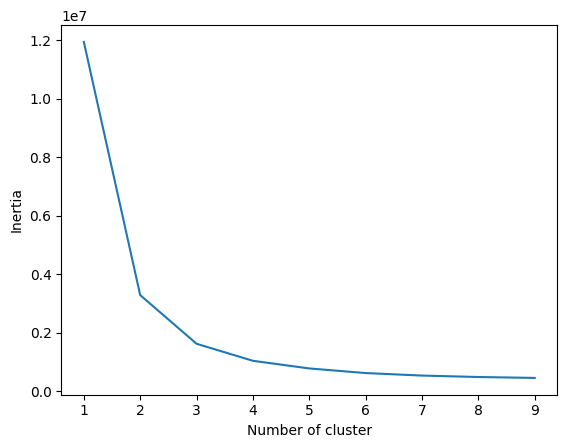

In [10]:
inertiaVals = {}

for k in range(1, 10):
    kmeansTmp = KMeans(n_clusters=k, max_iter=1000).fit(X_train)
    inertiaVals[k] = kmeansTmp.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

Here, I find the optimal amount of clusters for my PCA transformed X_train. It turns out that 3 is the optimal amount of clusters for my data, with and without PCA.

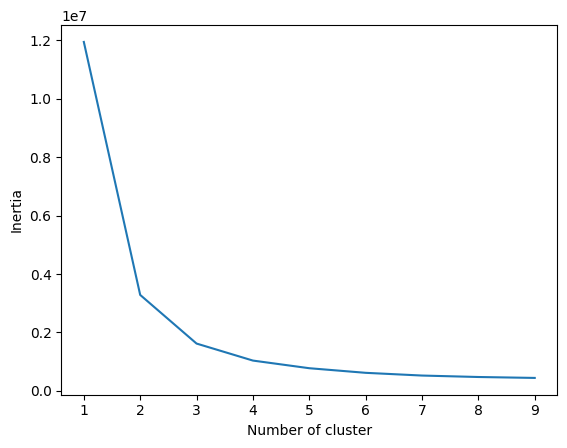

In [11]:
inertiaVals = {}

for k in range(1, 10):
    kmeansTmp_PCA = KMeans(n_clusters=k, max_iter=1000).fit(X_train_pca3)
    inertiaVals[k] = kmeansTmp_PCA.inertia_
plt.figure()
plt.plot(list(inertiaVals.keys()), list(inertiaVals.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Inertia")
plt.show()

Agglomerative Clustering, first on non PCA data, then on PCA transformed data.

Text(0, 0.5, 'Feature 1')

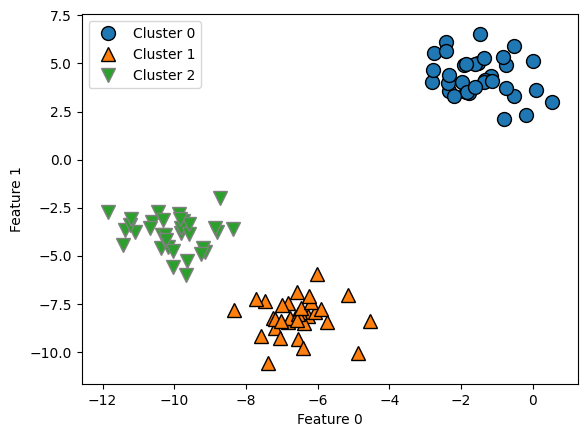

In [11]:
from sklearn.cluster import AgglomerativeClustering
X_train, y_train = sklearn.datasets.make_blobs(random_state=1)

agg = AgglomerativeClustering(n_clusters=3)
assignment = agg.fit_predict(X_train)

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

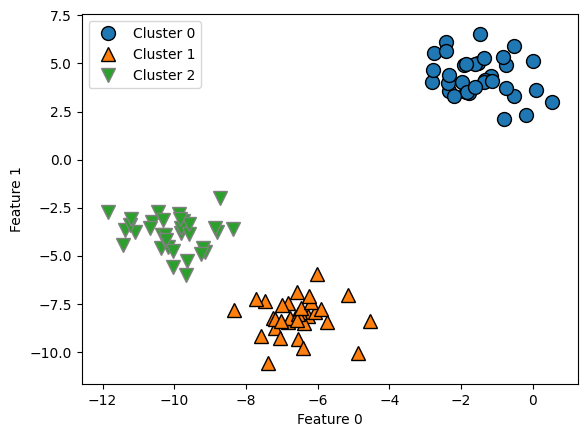

In [12]:
X_train_pca3, y_train = sklearn.datasets.make_blobs(random_state=1)

agg_pca = AgglomerativeClustering(n_clusters=3)
assignment_pca = agg_pca.fit_predict(X_train_pca3)

mglearn.discrete_scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], assignment_pca)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Here I perform DBSCAN on X_train and X_train_pca3.

Text(0, 0.5, 'Feature 1')

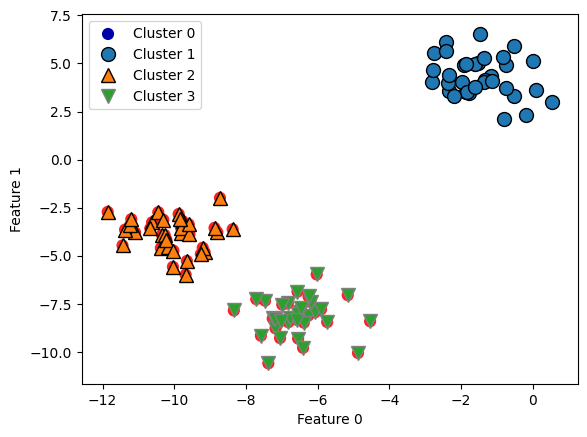

In [13]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=4,eps=2) #these paramaters made the best clusters
clusters = dbscan.fit_predict(X_train)

# plot the cluster assignments
plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Feature 1')

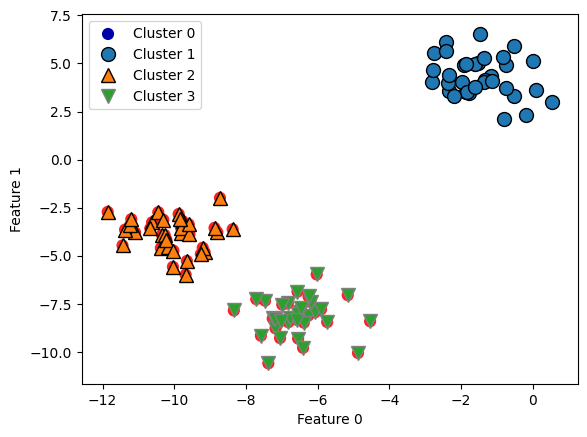

In [14]:
dbscan = DBSCAN(min_samples=4,eps=2)
clusters_pca = dbscan.fit_predict(X_train_pca3)

# plot the cluster assignments
plt.scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], c=clusters_pca, cmap=mglearn.cm2, s=60)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(X_train_pca3[:, 0], X_train_pca3[:, 1], clusters_pca)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Below are ARI and Silhouette Scores for X_train (non-pca).

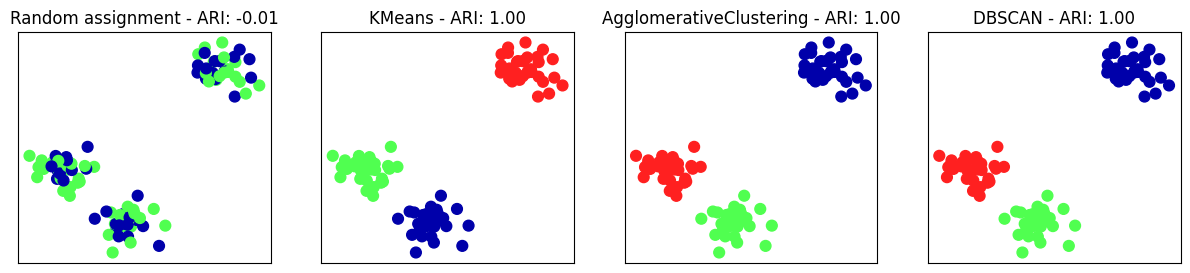

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

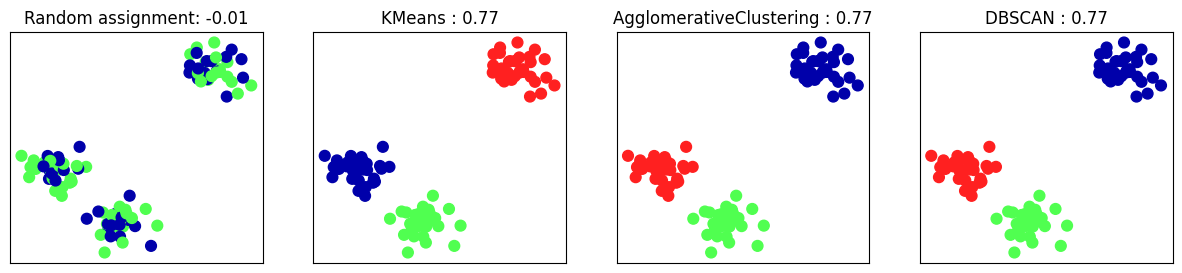

In [16]:
from sklearn.metrics.cluster import silhouette_score

# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))

Below are ARI and Silhoutte scores for PCA transformed data.

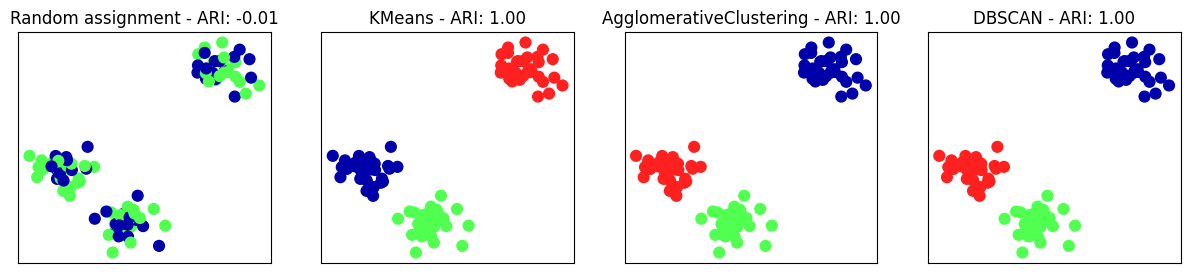

In [17]:
scaler = StandardScaler()
scaler.fit(X_train_pca3)
X_scaled = scaler.transform(X_train_pca3)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train_pca3))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
               cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

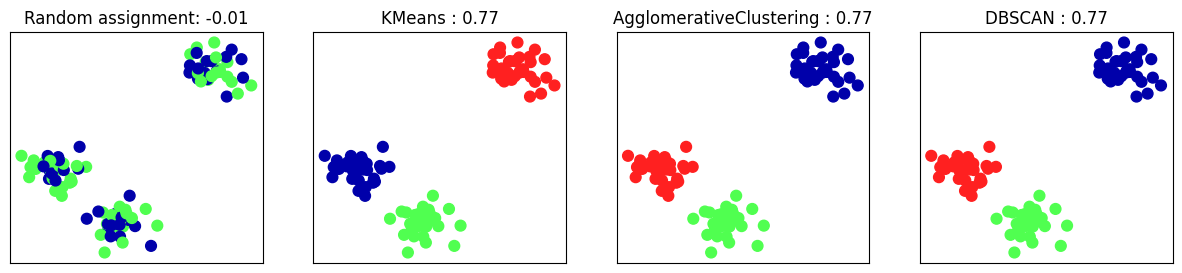

In [18]:
scaler = StandardScaler()
scaler.fit(X_train_pca3)
X_scaled = scaler.transform(X_train_pca3)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
                cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_scaled, random_clusters)))

algorithms = [KMeans(n_clusters=3), AgglomerativeClustering(n_clusters=3),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_scaled, clusters)))